<a href="https://colab.research.google.com/github/Vicente836/Practica-Ihealth/blob/S3/Algoritmo_variando_n_modos_test_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalación de librerías

In [1]:
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

--2024-12-18 12:22:53--  https://fem-on-colab.github.io/releases/gmsh-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3497 (3.4K) [application/x-sh]
Saving to: ‘/tmp/gmsh-install.sh’

/tmp/gmsh-install.s 100%[===================>]   3.42K  --.-KB/s    in 0s      

2024-12-18 12:22:53 (31.2 MB/s) - ‘/tmp/gmsh-install.sh’ saved [3497/3497]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ GMSH_INSTALLED=/usr/local/share/fem-on-colab/gmsh.installed
+ [[ ! -f /usr/local/share/fem-on-colab/gmsh.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/05fe520e/releases/h5py-install.sh
+ [[ https://gith

In [2]:
!pip install meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 9.9 MB/s eta 0:00:00


In [3]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123635 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libgl1-mesa-glx:amd64.
Preparing to unpack .../1-libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../2-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../3-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../4-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselec

In [4]:
import pyvista
pyvista.set_jupyter_backend('static')
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

In [31]:
import pyvista as pv
import os
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

# Generación modelo de test

In [15]:
pc = h5.File('UKBRVLV.h5', 'r') # components of PCA
f = 'connectivity.txt' # mesh connectivity
conn = np.loadtxt(f, dtype=int)

# Creates a mesh of the heart from the components of PCA (pc) and the variations fromm the mean of each mode (alpha).
def mesh_heart(alpha):
  n = len(alpha)
  # Create the n principal modes with alpha[i] times the standard deviation each
  S = np.transpose(pc['MU']) + sum( alpha[i]*np.sqrt(pc['LATENT'][0,i])*pc['COEFF'][i,:] for i in range(n))
  # get ED & convert to 3 columns matrix [x, y, z]
  N = S.shape[1] // 2
  points_ = np.reshape(S[0,:N], (-1,3))
  unwanted_nodes = (5630, 5655, 5696, 5729)
  points = np.delete(points_, unwanted_nodes, axis=0)
  faces = (np.c_[3*np.ones(conn.shape[0]),conn]).astype("int32").flatten()
  celltypes = np.full(conn.shape[0], fill_value=pv.CellType.TRIANGLE, dtype=np.uint8)
  mesh = pv.UnstructuredGrid(faces, celltypes, points)
  return mesh

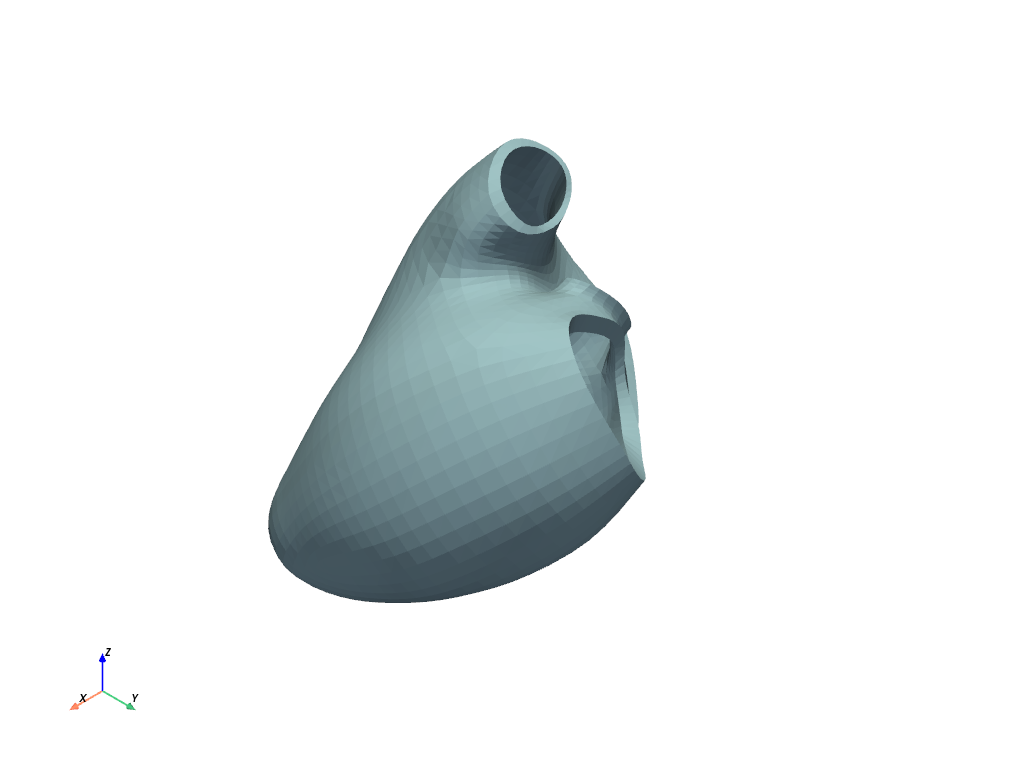

In [16]:
# True model to predict
alpha_real = np.array([1.5, 0.3, -0.8, 0.2, -0.3])
mesh = mesh_heart(alpha_real)
mesh.plot()

In [13]:
# create point cloud from multiple slices
def point_cloud(slices):
  point_cloud = []
  for sl in slices:
    points = sl.points
    point_cloud.extend(points)
  return pv.PolyData(point_cloud)

# Algoritmo usando mínimos cuadrados

In [17]:
from scipy.spatial import cKDTree
from numpy.linalg import lstsq

In [25]:
# True model to predict
alpha_real = np.array([1.5, 0.3, -0.8, 0.2, -0.3])

pc = h5.File('UKBRVLV.h5', 'r') # components of PCA

def points_heart(alpha):
  n = len(alpha)
  # Create the n principal modes with alpha[i] times the standard deviation each
  S = np.transpose(pc['MU']) + sum( alpha[i]*np.sqrt(pc['LATENT'][0,i])*pc['COEFF'][i,:] for i in range(n))
  # get ED & convert to 3 columns matrix [x, y, z]
  N = S.shape[1] // 2
  ed = np.reshape(S[0,:N], (-1,3))
  return np.array(ed)

def loss(alpha, data_points):
  X_points = points_heart(alpha)
  tree = cKDTree(X_points)
  idx_cp = tree.query(data_points)[1]
  return 0.5*np.mean(np.sum((X_points[idx_cp]- data_points)**2, axis = 1))

def lstsq_ATLAS(alpha, data_points):
  n = len(alpha)
  X_points = points_heart(alpha)
  tree = cKDTree(X_points)
  idx_cp = tree.query(data_points)[1]
  # procesamiento para tener las coordenadas de los vectores propios correspondientes a los cp
  N = data_points.shape[0]
  valp = pc['LATENT'][0,0:n]
  vecp = pc['COEFF'][0:n,:]
  k = vecp[0].shape[0] // 2
  vecp_ED = vecp[:,:k]
  vecp_ED_resh= np.array([np.reshape(v, (-1,3)) for v in vecp_ED ])
  vecp_ED_cp = (vecp_ED_resh[:, idx_cp]).reshape(n,-1)
  vecp_ED_cp_valp = np.array([np.sqrt(valp[i])*vecp_ED_cp[i] for i in range(n)] ) # multiplicamos por valores coeficientes 'latent'
  # coordenadas del modelo promedio asociadas a los cp
  mu = pc['MU']
  mu_ED = np.reshape(mu[:k], (-1,3))
  mu_ED_cp = mu_ED[idx_cp]

  alpha_, _, _, _ = lstsq(vecp_ED_cp_valp.T, (data_points-mu_ED_cp).flatten(), rcond=False)
  return alpha_

# algorithm that optimize parameters for PCA
def ATLAS_ICP(data_points, n_modes = 5, N_iter=5):
  # start with mean shape of the PCA
  alpha_ = np.zeros(n_modes)
  print('Valor de alpha inicial: ' + str(alpha_))
  loss_rec = []
  loss_real_rec = []
  for i in range(N_iter):
    alpha_  = lstsq_ATLAS(alpha_, data_points)
    loss_ = loss(alpha_, data_points)
    loss_rec.append(loss_)
    opt_points = points_heart(alpha_)
    loss_real = loss(alpha_real, opt_points)
    loss_real_rec.append(loss_real)
  print('Valor de alpha final: ' + str(alpha_))
  return alpha_, loss_rec, loss_real_rec

# Test del algoritmo

## Prueba usando 3 slices en eje z

In [152]:
# Lists to save real loss record and final alpha in each test
alpha_s = []
loss_real_s = []

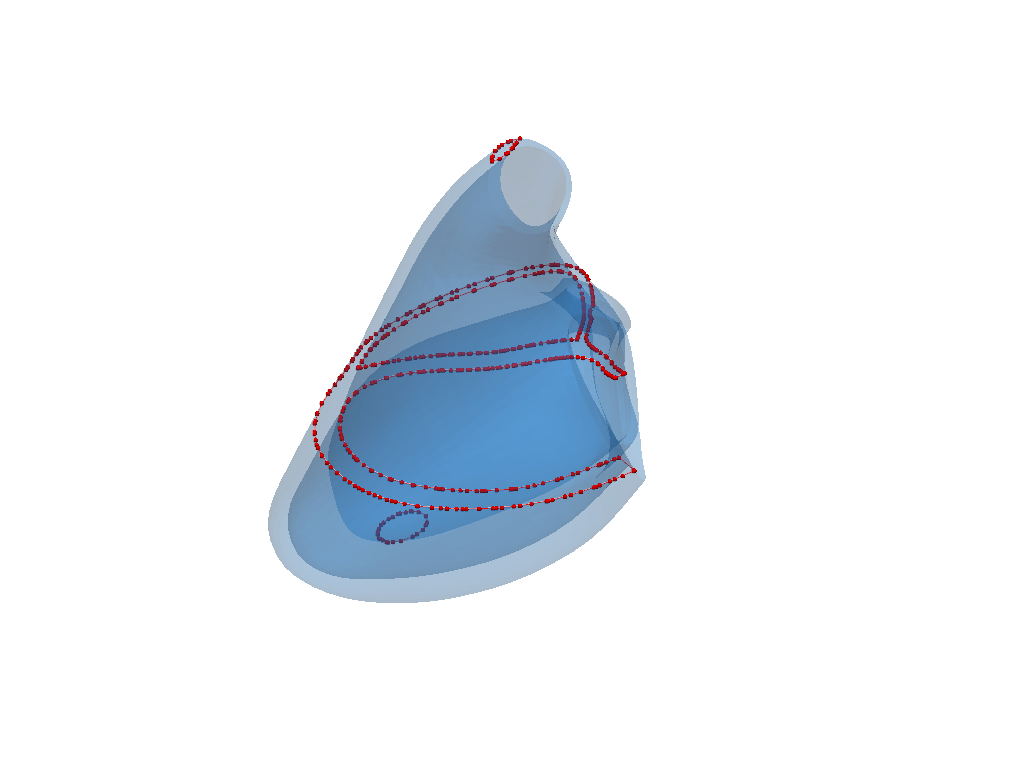

In [153]:
slices = mesh.slice_along_axis(n=3, axis="z")
data = point_cloud(slices)
p = pv.Plotter()
p.add_mesh(mesh, opacity = 0.2, render_points_as_spheres=True, color = 'dodgerblue')
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(slices, color = 'red', show_edges = True)
p.show()

In [154]:
data_points = data.points
modes = 5
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec, loss_real_rec  = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
err_real = loss(alpha_real, opt_points)
print('Valor de alpha real: ' + str(alpha_real))
print('Loss mínimo:' + str(min(loss_rec)))
print('Error real: ' + str(err_real))
alpha_s.append(alpha_opt)
loss_real_s.append(loss_real_rec)

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0.]
Valor de alpha final: [ 1.51561193  0.29221369 -0.82106573  0.24706456 -0.27053175]
Loss mínimo:0.5145163437654138
Valor de alpha real: [ 1.5  0.3 -0.8  0.2 -0.3]
Loss mínimo:0.5145163437654138
Error real: 0.0043167011284863804


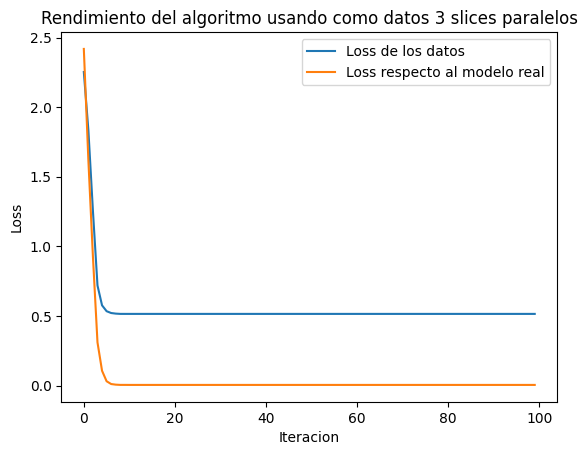

In [155]:
plt.plot(range(num_iter), loss_rec, label = 'Loss de los datos')
plt.plot(range(num_iter), loss_real_rec, label = 'Loss respecto al modelo real')
plt.title('Rendimiento del algoritmo usando como datos 3 slices paralelos')
plt.xlabel('Iteracion')
plt.ylabel('Loss')
plt.legend()
plt.show()

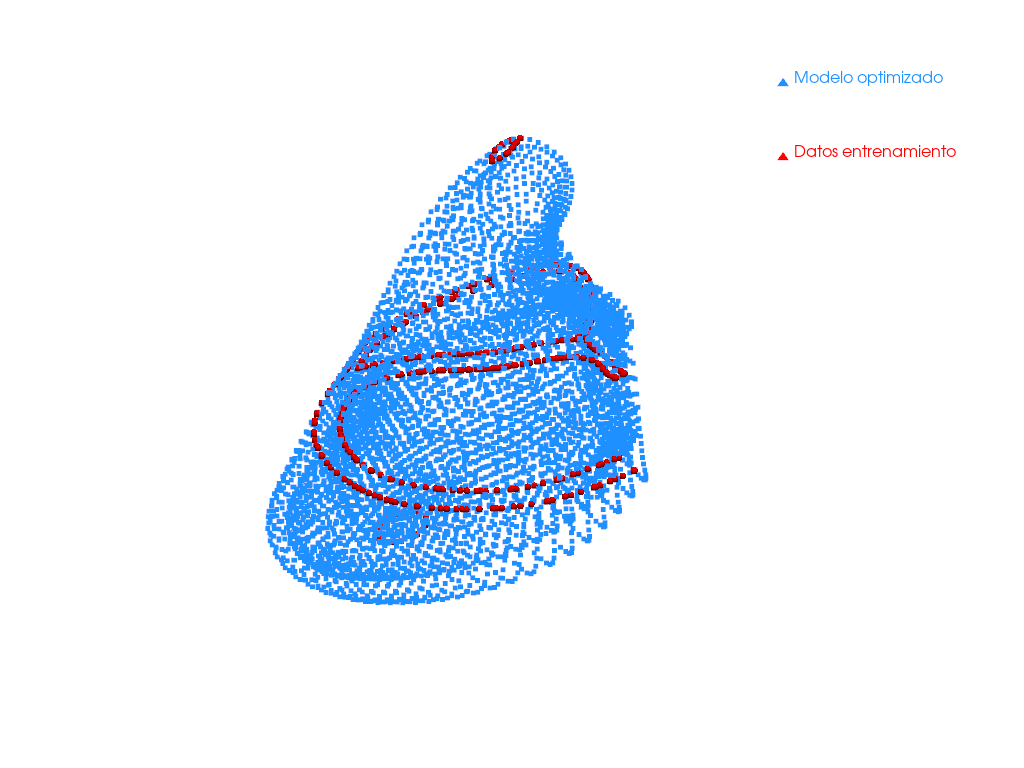

In [156]:
y = points_heart(alpha_opt)
z= points_heart(np.zeros(modes))
opti = pv.PolyData(y)
naive = pv.PolyData(z)
p = pv.Plotter()
p.add_mesh(opti, color = 'dodgerblue', label='Modelo optimizado')
p.add_mesh(data, point_size=7, render_points_as_spheres=True, color = 'red', label = 'Datos entrenamiento')
p.add_legend()
p.show()
#pv.save_meshio("optimizado.vtk", test)
#pv.save_meshio("datos.vtk", data)

## Prueba usando 3 slices ortogonales

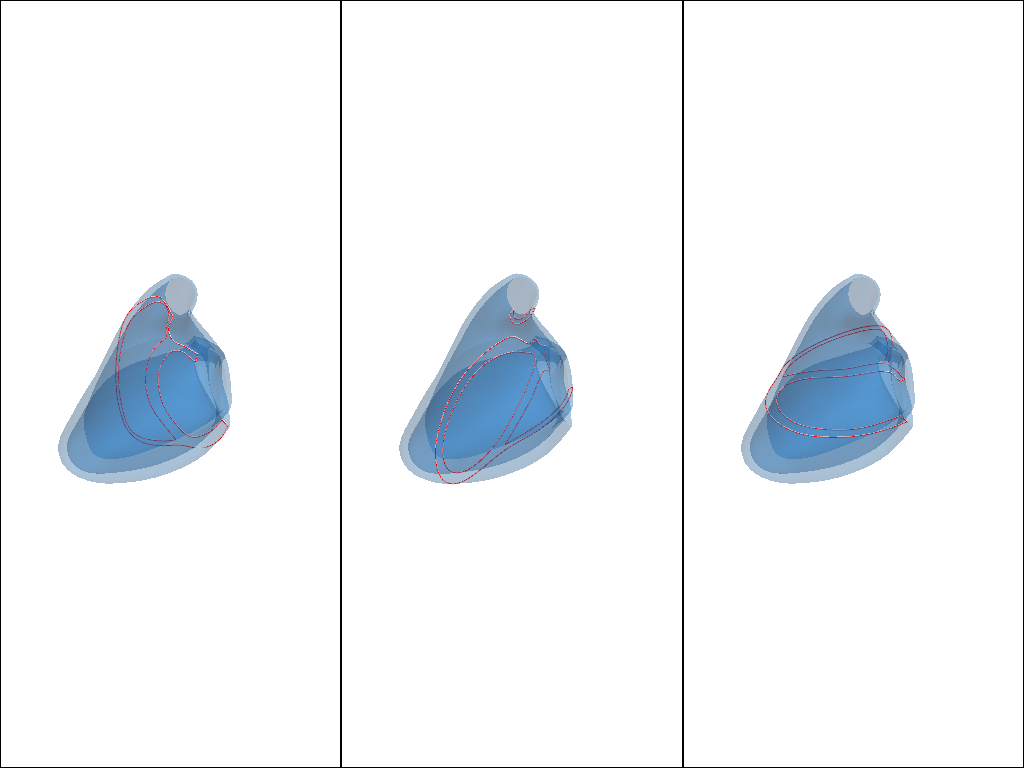

In [157]:
slices = mesh.slice_orthogonal()
data = point_cloud(slices)
p = pv.Plotter(shape=(1,3))
p.subplot(0,0)
p.add_mesh(mesh, opacity = 0.2, render_points_as_spheres=True, color = 'dodgerblue')
p.add_mesh(slices[0], color = 'red', show_edges = True)
p.subplot(0,1)
p.add_mesh(mesh, opacity = 0.2, render_points_as_spheres=True, color = 'dodgerblue')
p.add_mesh(slices[1], color = 'red', show_edges = True)
p.subplot(0,2)
p.add_mesh(mesh, opacity = 0.2, render_points_as_spheres=True, color = 'dodgerblue')
p.add_mesh(slices[2], color = 'red', show_edges = True)
p.show()

In [158]:
data_points = data.points
modes = 5
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec, loss_real_rec  = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
err_real = loss(alpha_real, opt_points)
print('Valor de alpha real: ' + str(alpha_real))
print('Loss mínimo:' + str(min(loss_rec)))
print('Error real: ' + str(err_real))
alpha_s.append(alpha_opt)
loss_real_s.append(loss_real_rec)

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0.]
Valor de alpha final: [ 1.50731398  0.2539824  -0.7942626   0.21063109 -0.3106779 ]
Loss mínimo:0.5049812865899316
Valor de alpha real: [ 1.5  0.3 -0.8  0.2 -0.3]
Loss mínimo:0.5049812865899316
Error real: 0.0017181866630369828


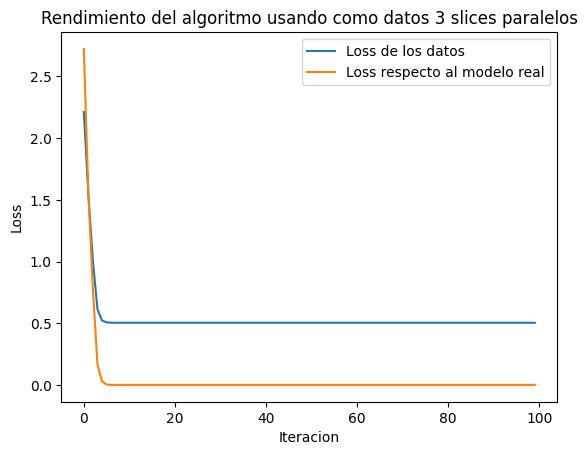

In [159]:
plt.plot(range(num_iter), loss_rec, label = 'Loss de los datos')
plt.plot(range(num_iter), loss_real_rec, label = 'Loss respecto al modelo real')
plt.title('Rendimiento del algoritmo usando como datos 3 slices paralelos')
plt.xlabel('Iteracion')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Pruebas usando slices ortogonales por separado

### Solo eje x

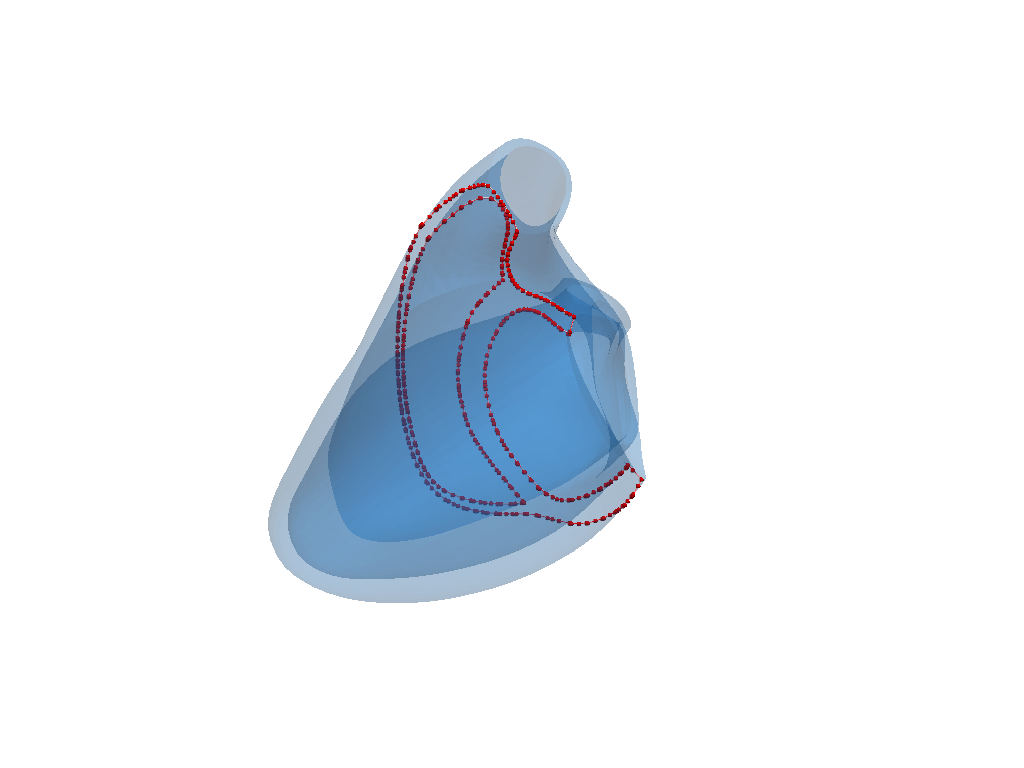

In [160]:
slices = mesh.slice_orthogonal()[0]
data = pv.PolyData(slices.points)
p = pv.Plotter()
p.add_mesh(mesh, opacity = 0.2, render_points_as_spheres=True, color = 'dodgerblue')
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(slices, color = 'red', show_edges = True)
p.show()

In [161]:
data_points = data.points
modes = 5
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec, loss_real_rec  = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
err_real = loss(alpha_real, opt_points)
print('Valor de alpha real: ' + str(alpha_real))
print('Loss mínimo:' + str(min(loss_rec)))
print('Error real: ' + str(err_real))
alpha_s.append(alpha_opt)
loss_real_s.append(loss_real_rec)

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0.]
Valor de alpha final: [ 1.52965964  0.24214375 -0.76302348  0.26191401 -0.34447296]
Loss mínimo:0.5290626994306722
Valor de alpha real: [ 1.5  0.3 -0.8  0.2 -0.3]
Loss mínimo:0.5290626994306722
Error real: 0.015446566468832197


### Solo eje y

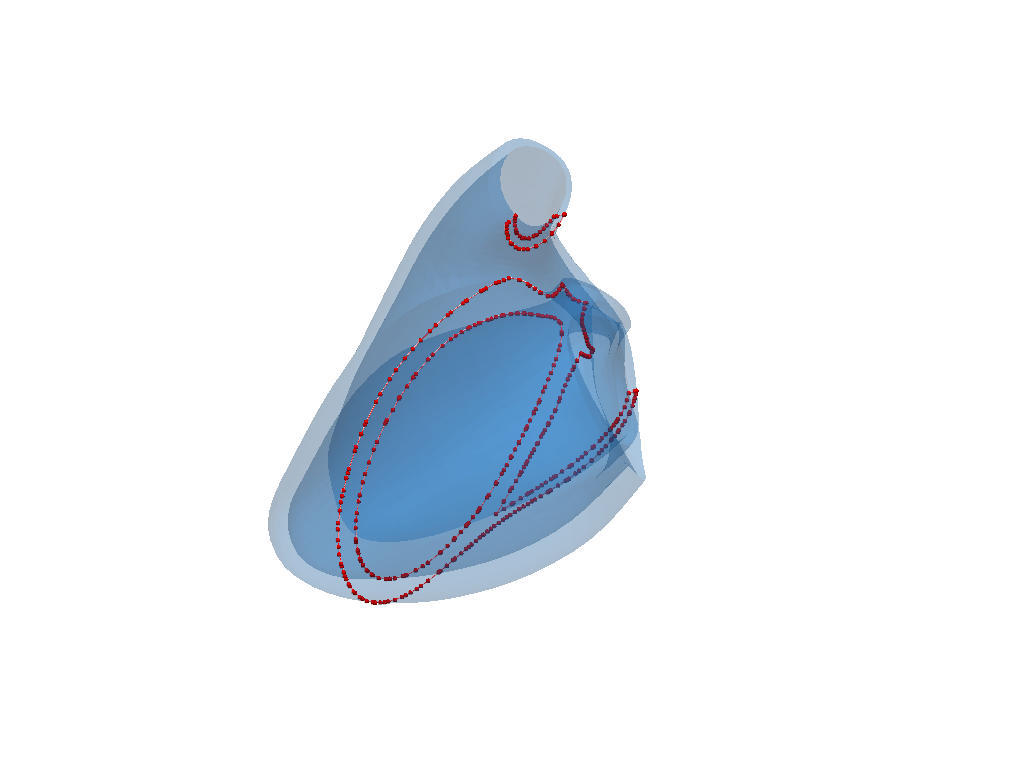

In [162]:
slices = mesh.slice_orthogonal()[1]
data = pv.PolyData(slices.points)
p = pv.Plotter()
p.add_mesh(mesh, opacity = 0.2, render_points_as_spheres=True, color = 'dodgerblue')
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(slices, color = 'red', show_edges = True)
p.show()

In [163]:
data_points = data.points
modes = 5
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec, loss_real_rec  = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
err_real = loss(alpha_real, opt_points)
print('Valor de alpha real: ' + str(alpha_real))
print('Loss mínimo:' + str(min(loss_rec)))
print('Error real: ' + str(err_real))
alpha_s.append(alpha_opt)
loss_real_s.append(loss_real_rec)

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0.]
Valor de alpha final: [ 1.50795825  0.26336497 -0.74420212  0.12957146 -0.34038083]
Loss mínimo:0.4635973997375969
Valor de alpha real: [ 1.5  0.3 -0.8  0.2 -0.3]
Loss mínimo:0.4635973997375969
Error real: 0.005488183015057059


### Solo eje z

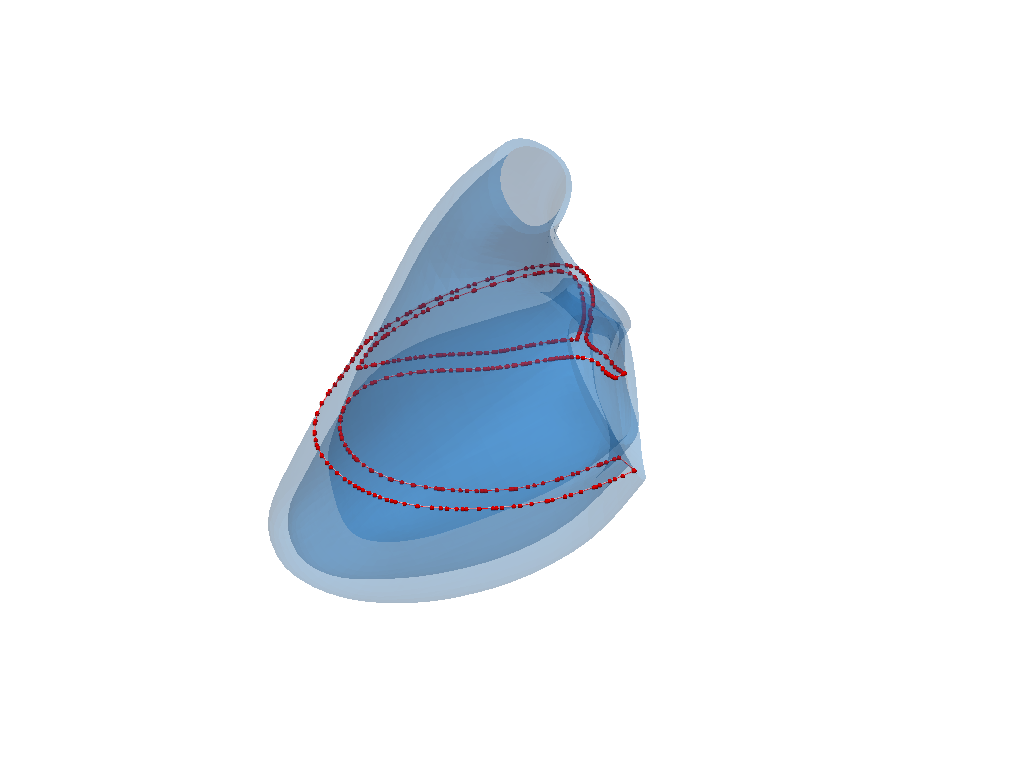

In [164]:
slices = mesh.slice_orthogonal()[2]
data = pv.PolyData(slices.points)
p = pv.Plotter()
p.add_mesh(mesh, opacity = 0.2, render_points_as_spheres=True, color = 'dodgerblue')
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(slices, color = 'red', show_edges = True)
p.show()

In [165]:
data_points = data.points
modes = 5
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec, loss_real_rec  = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
err_real = loss(alpha_real, opt_points)
print('Valor de alpha real: ' + str(alpha_real))
print('Loss mínimo:' + str(min(loss_rec)))
print('Error real: ' + str(err_real))
alpha_s.append(alpha_opt)
loss_real_s.append(loss_real_rec)

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0.]
Valor de alpha final: [ 1.50315296  0.31331811 -0.86158473  0.27807358 -0.26223938]
Loss mínimo:0.516443110158255
Valor de alpha real: [ 1.5  0.3 -0.8  0.2 -0.3]
Loss mínimo:0.516443110158255
Error real: 0.007446775068326943


# Resultados finales

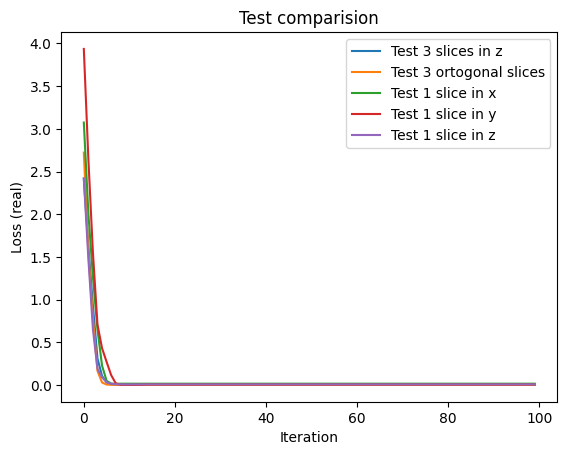

In [166]:
plt.plot(range(num_iter), loss_real_s[0], label = 'Test 3 slices in z')
plt.plot(range(num_iter), loss_real_s[1], label = 'Test 3 ortogonal slices')
plt.plot(range(num_iter), loss_real_s[2], label = 'Test 1 slice in x')
plt.plot(range(num_iter), loss_real_s[3], label = 'Test 1 slice in y')
plt.plot(range(num_iter), loss_real_s[4], label = 'Test 1 slice in z')
plt.title('Test comparision')
plt.xlabel('Iteration')
plt.ylabel('Loss (real)')
plt.legend()
plt.show()

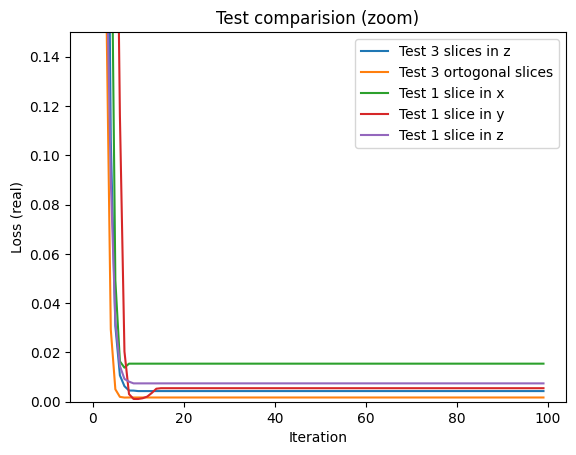

In [167]:
plt.plot(range(num_iter), loss_real_s[0], label = 'Test 3 slices in z')
plt.plot(range(num_iter), loss_real_s[1], label = 'Test 3 ortogonal slices')
plt.plot(range(num_iter), loss_real_s[2], label = 'Test 1 slice in x')
plt.plot(range(num_iter), loss_real_s[3], label = 'Test 1 slice in y')
plt.plot(range(num_iter), loss_real_s[4], label = 'Test 1 slice in z')
plt.ylim((0,0.15))
plt.title('Test comparision (zoom)')
plt.xlabel('Iteration')
plt.ylabel('Loss (real)')
plt.legend()
plt.show()

In [168]:
import pandas as pd

# Define column data
al = alpha_s
al.insert(0, alpha_real)
data = {
    "Test": ['Real value', '3 slices along z axis', '3 ortognal slices', '1 slice along x axis', '1 slice along y axis', '1 slice along z axis'],
    "Final alpha": [np.round(a,4) for a in al]
}
df = pd.DataFrame(data)
df

,Test,Final alpha
0,Real value,"[1.5, 0.3, -0.8, 0.2, -0.3]"
1,3 slices along z axis,"[1.5156, 0.2922, -0.8211, 0.2471, -0.2705]"
2,3 ortognal slices,"[1.5073, 0.254, -0.7943, 0.2106, -0.3107]"
3,1 slice along x axis,"[1.5297, 0.2421, -0.763, 0.2619, -0.3445]"
4,1 slice along y axis,"[1.508, 0.2634, -0.7442, 0.1296, -0.3404]"
5,1 slice along z axis,"[1.5032, 0.3133, -0.8616, 0.2781, -0.2622]"
